In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'
geometry = None # [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

QubitHamiltonian

(-0.32760818995565577+0j) [] +
(-0.04919764587885283+0j) [X0 X1 Y2 Y3] +
(0.04919764587885283+0j) [X0 Y1 Y2 X3] +
(0.04919764587885283+0j) [Y0 X1 X2 Y3] +
(-0.04919764587885283+0j) [Y0 Y1 X2 X3] +
(0.1371657293179602+0j) [Z0] +
(0.15660062486143395+0j) [Z0 Z1] +
(0.10622904488350779+0j) [Z0 Z2] +
(0.15542669076236065+0j) [Z0 Z3] +
(0.1371657293179602+0j) [Z1] +
(0.15542669076236065+0j) [Z1 Z2] +
(0.10622904488350779+0j) [Z1 Z3] +
(-0.13036292044009176+0j) [Z2] +
(0.1632676867167479+0j) [Z2 Z3] +
(-0.13036292044009176+0j) [Z3]

In [2]:
from quchem.Ansatz_Generator_Functions import *


ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)



Sec_Quant_CC_ops_ia, Sec_Quant_CC_ops_ijab, theta_parameters_ia, theta_parameters_ijab=ansatz_obj.Get_ia_and_ijab_terms(single_cc_amplitudes=None, 
                                                                                                             double_cc_amplitudes=None, 
                                                                                                             singles_hamiltonian=None,
                                                                                                             doubles_hamiltonian=None, 
                                                                                                             tol_filter_small_terms = None)

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ops_ia,
                                                                                                                    Sec_Quant_CC_ops_ijab)
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, 
                                                              theta_parameters_ijab)

print(ansatz_cirq_circuit.to_text_diagram(transpose=True)) 

0         1         2         3
│         │         │         │
X         X         H         H
│         │         │         │
Rx(0.5π)  │         │         │
│         │         │         │
@─────────X         │         │
│         │         │         │
│         @─────────X         │
│         │         │         │
│         │         Rz(-0.0π) │
│         │         │         │
│         @─────────X         │
│         │         │         │
@─────────X         H         │
│         │         │         │
Rx(-0.5π) │         Rx(0.5π)  │
│         │         │         │
H         │         │         │
│         │         │         │
@─────────X         │         │
│         │         │         │
│         @─────────X         │
│         │         │         │
│         │         Rz(0.0π)  │
│         │         │         │
│         @─────────X         │
│         │         │         │
@─────────X         Rx(-0.5π) │
│         │         │         │
H         Rx(0.5π)  │         │
│       

In [3]:
from quchem.Simulating_Quantum_Circuit import *

In [4]:
n_shots= 1000


def VQE_experiment_ENERGY(theta_ia_ijab_combined_list):
    theta_params_ia = [theta_ia_ijab_combined_list[0], theta_ia_ijab_combined_list[1]]
    theta_params_ijab = [theta_ia_ijab_combined_list[2]]
    
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_params_ia, 
                                                              theta_params_ijab)
    

    VQE_exp = VQE_Experiment(QubitHamiltonian, ansatz_cirq_circuit, n_shots)
    return VQE_exp.Calc_Energy().real

In [5]:
theta_combined = [1,2, np.pi]

VQE_experiment_ENERGY(theta_combined)

-0.3918590464423547

In [6]:
import random

theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(Sec_Quant_CC_ops_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(Sec_Quant_CC_ops_ijab))]

theta_combined_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

0: Input_to_Funct: [2.79722954 4.33557658 2.20133307]: Output: -0.6883303539341481
1: Input_to_Funct: [2.79722954 4.33557658 2.20133307]: Output: -0.6913302344263443
2: Input_to_Funct: [2.79722954 4.33557658 2.20133307]: Output: -0.6773837918623729
3: Input_to_Funct: [2.53247119 4.54967913 2.29839361]: Output: -0.720361691995495
4: Input_to_Funct: [2.2907353  4.66437692 2.18192096]: Output: -0.7732813487360645
5: Input_to_Funct: [2.09504435 4.37380918 2.37215962]: Output: -0.8547429896604166
6: Input_to_Funct: [2.09504435 4.37380918 2.37215962]: Output: -0.8244395525819261
7: Input_to_Funct: [2.09504435 4.37380918 2.37215962]: Output: -0.8167217083924571
8: Input_to_Funct: [2.02981403 4.34577194 2.19097995]: Output: -0.9376171272714114
9: Input_to_Funct: [2.02981403 4.34577194 2.19097995]: Output: -0.94767316670615
10: Input_to_Funct: [2.02981403 4.34577194 2.19097995]: Output: -0.9471483888311469
11: Input_to_Funct: [2.02981403 4.34577194 2.19097995]: Output: -0.9541480135301404
12: I

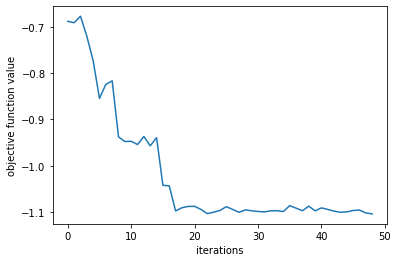

In [7]:
### optimizer
from quchem.Scipy_Optimizer import *

GG = Optimizer(VQE_experiment_ENERGY, theta_combined_random_input, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

In [8]:
Hamilt.molecule.fci_energy

array(-1.10115033)

### Tensorflow

In [ ]:
from quchem.TensorFlow_Opt import *

**gradient is given by**

https://arxiv.org/pdf/1906.08728.pdf

$$\frac{\partial O(\theta)}{\partial \theta}=\left\langle\overrightarrow{0}\left|\hat{U}^{\dagger} \hat{R}_{y}^{C \dagger}(\theta+\pi / 4) \hat{V}^{\dagger} \hat{O} \hat{V} \hat{R}_{y}^{C}(\theta+\pi / 4) \hat{U}\right| \overrightarrow{0}\right\rangle -\left\langle\overrightarrow{0}\left|\hat{U}^{\dagger} \hat{R}_{y}^{C \dagger}(\theta-\pi / 4) \hat{V}^{\dagger} \hat{O} \hat{V} \hat{R}_{y}^{C}(\theta-\pi / 4) \hat{U}\right| \overrightarrow{0}\right\rangle$$

$$\frac{\partial O(\theta)}{\partial \theta} =O(\theta+\pi / 4)-O(\theta-\pi / 4)$$

In [ ]:
def calc_gradient(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = VQE_experiment_ENERGY(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = VQE_experiment_ENERGY(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append((gradient, theta))
        

    return grad_list

note:
this is very SLOW as it has to run a separate experiment TWICE for each parameter before taking a step!

In [ ]:
X0 = [random.uniform(0, 2*np.pi) for _ in range(len(Sec_Quant_CC_ops_ia) + len(Sec_Quant_CC_ops_ijab))]

tf_opt = Tensor_Flow_Optimizer(VQE_experiment_ENERGY, X0, 'Adam', calc_gradient, learning_rate=0.1, beta1=0.9,
                            beta2=0.999, store_values=True, display_iter_steps=True)
tf_opt.optimize(50)
tf_opt.plot_convergence()

In [ ]:
from quchem.Adam_Optimizer import *

In [ ]:
def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = VQE_experiment_ENERGY(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = VQE_experiment_ENERGY(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

In [ ]:
X0 = np.array([random.uniform(0, 2*np.pi) for _ in range(len(Sec_Quant_CC_ops_ia) + len(Sec_Quant_CC_ops_ijab))])

opt_params, list_of_inputs, list_of_outputs = Adam_Opt(X0, VQE_experiment_ENERGY,
                                                       calc_gradient_ADAM, 
                                                       learning_rate=0.1, 
                                                       beta_1=0.9, 
                                                       beta_2=0.999, 
                                                       epsilon=1e-8,
                                                       max_iter=50,
                                                       disp=True,
                                                       tolerance=1e-3,
                                                       store_steps=True)

VQE_experiment_ENERGY(opt_params)

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline
plt.figure()
plt.plot(list_of_outputs)
plt.xlabel('iterations')
plt.ylabel('objective function value')
plt.show()